### Forecast experiment 2 - Flight passenger data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import keras
import seaborn as sns

# in time series forecasting, we usually need to scale our values
# for better end results
from sklearn.preprocessing import MinMaxScaler

In [2]:
# let's try a pandas DataFrame instead
df = sns.load_dataset("flights")

In [3]:
df

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


**Before going any further, scale the values in our DataFrame**

In [4]:
# scale the values with MinMaxScaler so that we don't
# affect the distribution of data (thus making the signal not realistic anymore)
# MinMaxScaler is a good solution here
scaler = MinMaxScaler()
df[['passengers']] = scaler.fit_transform(df[['passengers']])

# as weird as it sounds, scaling the index/sequence number also
# to be a decimal might affect the performance of the network
df.index = df.index * 0.1 + 1

In [5]:
df

,year,month,passengers
1.0,1949,Jan,0.015444
1.1,1949,Feb,0.027027
1.2,1949,Mar,0.054054
1.3,1949,Apr,0.048263
1.4,1949,May,0.032819
...,...,...,...
14.9,1960,Aug,0.969112
15.0,1960,Sep,0.779923
15.1,1960,Oct,0.689189
15.2,1960,Nov,0.552124


In [6]:
# let's figure out a good cutoff point for train/test
# 67% for training, 33% testing (NOTE: you should experiment on this to find optimal %)
cutoff = int(len(df) * 0.67)

# train data
X_train = df.index[0:cutoff]
y_train = df['passengers'].iloc[0:cutoff]

# test data
X_test = df.index[cutoff:]
y_test = df['passengers'].iloc[cutoff:]

# convert everything into NumPy -array format
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# in this case, number of variables is 1 => scaled passengers value
n_features = 1

# use reshape tools to get the data ready for future use
train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))


In [7]:
train_series

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984556],
       [0.08494208],
       [0.08494208],
       [0.06177606],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123552],
       [0.04247104],
       [0.07142857],
       [0.05984556],
       [0.04054054],
       [0.08687259],
       [0.12741313],
       [0.12741313],
       [0.1042471 ],
       [0.05598456],
       [0.01930502],
       [0.06949807],
       [0.07915058],
       [0.08880309],
       [0.14285714],
       [0.11389961],
       [0.13127413],
       [0.14285714],
       [0.18339768],
       [0.18339768],
       [0.15444015],
       [0.11196911],
       [0.08108108],
       [0.11969112],
       [0.12934363],
       [0.14671815],
       [0.17181467],
       [0.14864865],
       [0.15250965],
       [0.22007722],
       [0.24324324],
       [0.26640927],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

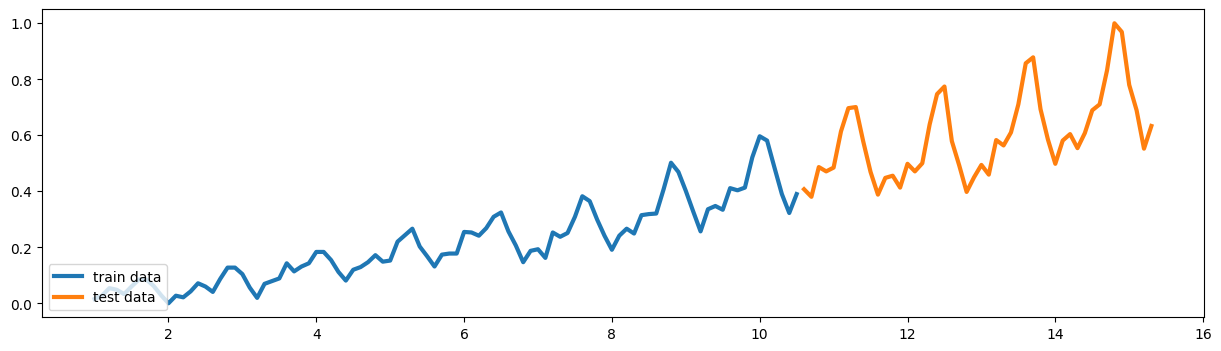

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(X_train,y_train, lw=3, label='train data')
ax.plot(X_test, y_test,  lw=3, label='test data')
ax.legend(loc="lower left")
plt.show()

In [9]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# the variable that determines how many points
# back into the past the model attempts to learn
look_back  = 12
batch_size = 1

# stride = 1 => means we use separate time steps
# more than 1 => we use windowing

# TimeseriesGenerators were deprecated by TensorFlow developers
# during October 2024
# this means, in some unknown future TensorFlow -version
# this feature will removed
# check the other version of this notebook on how to replace
# TimeseriesGenerator with a TensorFlow Dataset
train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = batch_size)

In [10]:
from keras.models import Sequential
from keras import Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

# create a model checkpoint to a file, and only save the best one
mc = ModelCheckpoint('best_model_flights.keras', monitor='val_loss', mode='min', save_best_only=True)
callback_list = [mc]

# build the neural network
# in this case, LSTM with 8 neurons
n_neurons  = 64

model = Sequential()
model.add(Input(shape=(look_back, n_features)))
model.add(SimpleRNN(n_neurons, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

initial_weights = model.get_weights()

# it's not optimal to use test data as validation data
# because this might skew our metrics
# see the other version of this notebook on how to do
# train/validation/test -split for the sine wave
model.fit(train_generator, epochs=200, verbose=1, validation_data=test_generator, callbacks=callback_list)


Epoch 1/200


c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0224 - val_loss: 0.0547
Epoch 2/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - val_loss: 0.0371
Epoch 3/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045 - val_loss: 0.0128
Epoch 4/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0113
Epoch 5/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - val_loss: 0.0098
Epoch 6/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0097
Epoch 7/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - val_loss: 0.0083
Epoch 8/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - val_loss: 0.0070
Epoch 9/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0072
Epoch 10/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 0.0102
Epoch 11/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - val_loss: 0.0115
Epoch 12/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_lo

**Training metrics**

<Axes: >

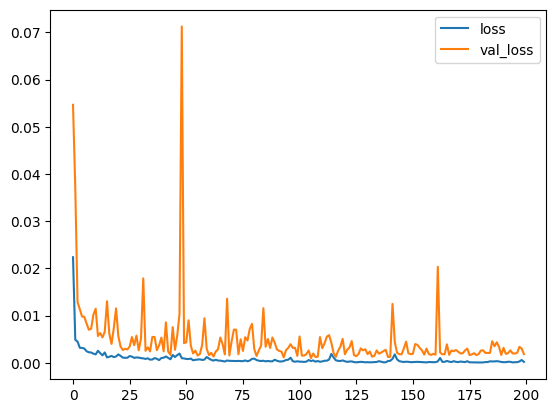

In [11]:
# the usual training metrics visualization
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [12]:
# reload the best version of the model
from keras.models import load_model
model = load_model("best_model_flights.keras")

In [13]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# these values are very close to each other, 
# which means our model is quite optimal
# IN THEORY 

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2159e-04  
Training loss: 0.00022158522915560752
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8263e-04 
Testing loss: 0.0009826277382671833


**Test predictions**

In [14]:
test_predictions  = model.predict(test_generator)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


**Conventional regression metrics + MAPE**

In [15]:
# let's make a separate copy of the test values
# so we can calculate some errors

actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = mean_absolute_percentage_error(actual_y_test, test_predictions) * 100

# print out the MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

# MAE - Mean average error
print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test, test_predictions), 2), "units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), "units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test, test_predictions)), 2), "units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test, test_predictions), 2))

MAPE (mean average precision error):
4.28 %

MAE
0.03 units

MSE
0.0 units^2

RMSE:
0.03 units

R-squared:
0.96


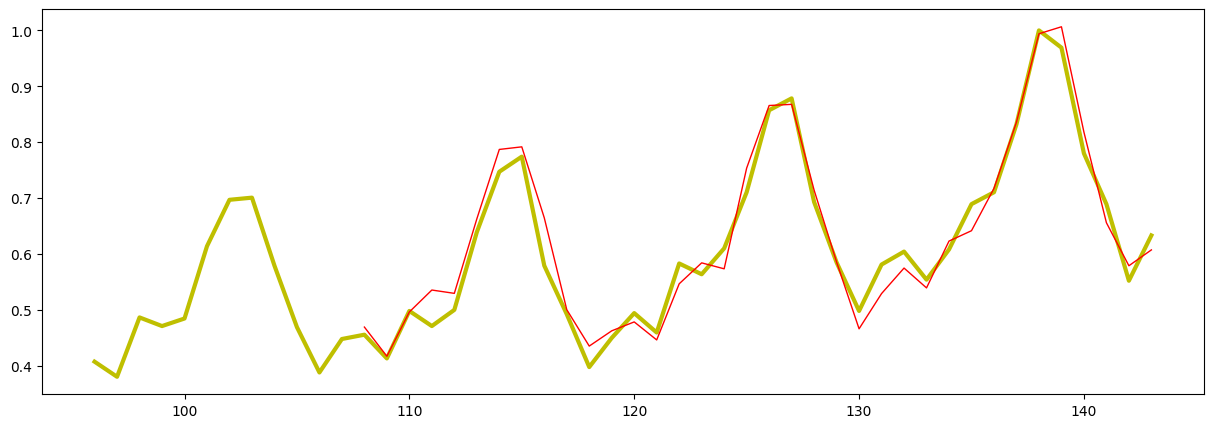

In [16]:
# calculate helper x-variables for where the train data starts
# where the test data starts and where the predictions start
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(y_test))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, test_predictions, lw=1, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()

In [17]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# some difference here which we can see in the test-signal prediction already 

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2159e-04
Training loss: 0.00022158522915560752
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8263e-04 
Testing loss: 0.0009826277382671833


**Extrapolation into the future**

In [18]:
# EXTRAPOLATION TEST 1 - 180 new points
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

# extrapolate the next 180 values
for i in range(120):
    predicted_value = model.predict(current_batch, verbose=None)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

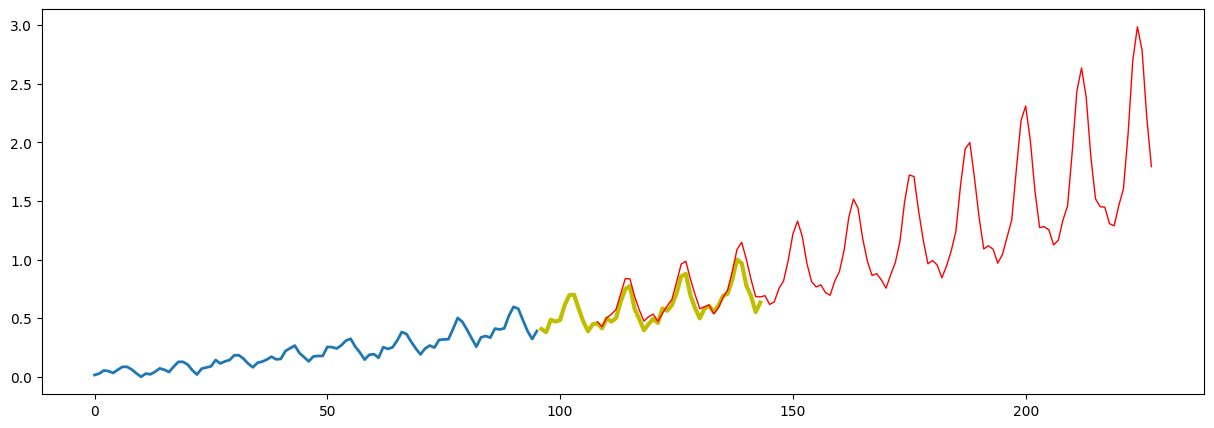

In [19]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()

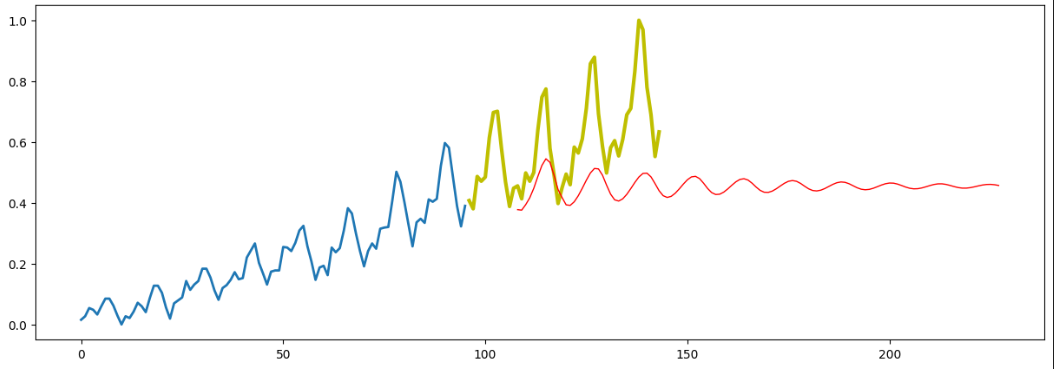

This can be considered as vanishing gradient, where the network as the training goes by, doesn't learn anything new, and the gradients start to decrease => resulting in a shrinking prediction in the future. This model is really not that usable in real life.

On the other hand, if you have a future prediction that completely explodes towards the ceiling (exponential growth), then it's called "exploding gradient". 

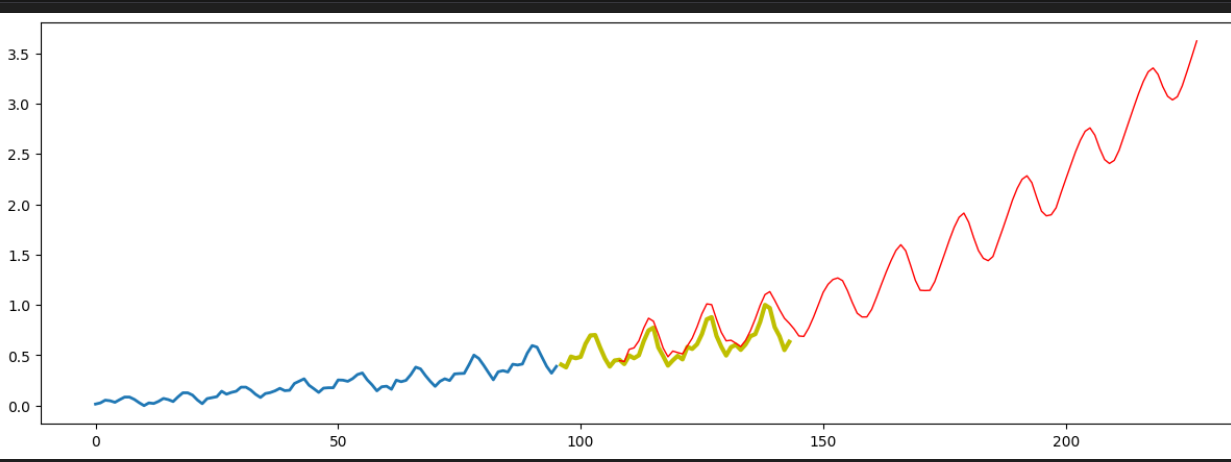

Since forecasting models are quite limited in performance, and it's virtually impossible to just make one forecasting model that works on every situation and data. Since any change in data or neural network structure might ruin the forecasting model performance, you usually want to create multiple forecasting models with different specifications (for example, RNN 64 nodes, RNN 32 nodes, LSTM 32 nodes etc. etc.)

So if we have multiple models, how do we automatically choose the best one? 

Answer: use standard deviation and variance values to compare suitable thresholds when the extrapolated trend seems to be good.

Even though RNN only focuses on short-term trends (because it doesn't have anything that allows capturing long term trends), LSTM usually doesn't perform that much better. The reason for this, even though LSTM is capable of capturing long-term trends (in theory), it still emphasizes recent trends the most.

Forecasting models are at their best, when they are just components of a certain smarter system, i.e. a collection models, where you also have conventional code that makes the decision of the predicted situation. For example, 6 models out of 8 predict that it's going to be a bad weather tomorrow => we can select "YES" as the answer for our system.
